In [2]:
import numpy as np
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from tqdm import tqdm

from sentence_transformers import SentenceTransformer

if 'embedding_model' not in locals():
    embedding_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, device='cuda:0')

import pickle

import ast
import re


def safe_to_list(val, dataset_name):
    """Safely convert a malformed list-like string into a real Python list."""
    if isinstance(val, list):
        return val
    if not isinstance(val, str):
        return []

    val = val.replace('\n', " ")
    while "  " in val:
        val = val.replace("  ", " ")

    val = val.replace(" ", ", ")

    # Try to parse clean Python-like lists first
    try:
        result = ast.literal_eval(val)
        if isinstance(result, list):
            return result
        return [result]
    except (ValueError, SyntaxError):
        pass


    # Handle broken or concatenated lists without commas
    # Example: "['dataset:subject=algebra--id178' 'dataset:subject=algebra--id184']"
    pattern = rf"{re.escape(dataset_name)}:[\w-]+--id\d+"
    tokens = re.findall(pattern, val)
    if tokens:
        return tokens

    # Fallback: split by spaces if still malformed
    cleaned = val.strip("[]").replace("\n", " ")
    return [t for t in cleaned.split(" ") if t]

dataset_dict = {
    # MATH dataset subjects
    "math:subject=algebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=counting_and_probability": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=geometry": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=intermediate_algebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=number_theory": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=prealgebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=precalculus": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },

    # WMT14 language pairs (use meteor score, sample=0.2)
    "wmt_14:language_pair=cs-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=de-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=fr-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=hi-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=ru-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },

    # MEDQA (embed_model=onehot)
    "med_qa": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },

    # LegalBench subsets (embed_model=onehot)
    "legalbench:subset=abercrombie": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=international_citizenship_questions": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=corporate_lobbying": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=function_of_decision_section": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=proa": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
}

In [3]:
n_sample_list = [1,4,16,64]

error_dict = {}

for dataset in dataset_dict:
    error_dict[dataset] = {}
    print(dataset)
    
    score_col = dataset_dict[dataset]['score_col']
    outdir=dataset_dict[dataset]['outdir']
    outdir = Path(outdir)
    outpath = outdir / f'{dataset}-{score_col}-cluster-res.tsv'
    df_res = pd.read_csv(outpath, delimiter='\t')

    dkps_cols = [c for c in df_res.columns if 'p_' in c]
    for c in dkps_cols:
        df_res[c] = df_res[c].clip(0, 1)

    max_samples        = df_res.n_samples.max()


    for n_sample in n_sample_list:
        subset = df_res[df_res['n_samples'] == n_sample].copy()
        p_interp = (
            subset["n_samples"] * subset["p_sample"]
            + (max_samples - subset["n_samples"]) * subset["p_lr_dkps8__n_components_cmds=8__n_models=ALL"]
        ) / max_samples
    
        e_interp = np.abs(p_interp - subset["y_act"])
        
        avg_mean_e_interp = np.mean(e_interp)

        error_dict[dataset][n_sample] = avg_mean_e_interp
    print(np.array(list(error_dict[dataset].values())))

math:subject=algebra
[0.19544629 0.10939087 0.07927023 0.03463917]
math:subject=counting_and_probability
[0.16474574 0.1405558  0.08490913 0.0302506 ]
math:subject=geometry
[0.14494919 0.12996592 0.08125397 0.02603738]
math:subject=intermediate_algebra
[0.15068647 0.12314776 0.07867524 0.02712961]
math:subject=number_theory
[0.18479668 0.11623489 0.07877284 0.02358105]
math:subject=prealgebra
[0.1515305  0.11015823 0.08698243 0.057365  ]
math:subject=precalculus
[0.20338111 0.12735865 0.0837544  0.03706249]
wmt_14:language_pair=cs-en
[0.03538358 0.02969879 0.03991578 0.0343534 ]
wmt_14:language_pair=de-en
[       nan 0.02789593 0.02725502 0.0467131 ]
wmt_14:language_pair=fr-en
[       nan 0.02180105 0.03272338 0.04057724]
wmt_14:language_pair=hi-en
[       nan        nan 0.05160248 0.04443841]
wmt_14:language_pair=ru-en
[0.04784515        nan 0.04562986 0.03589372]
med_qa
[0.12917864 0.1126339  0.06493847 0.04867456]
legalbench:subset=abercrombie
[0.12043552 0.10909542 0.06961268 0.041

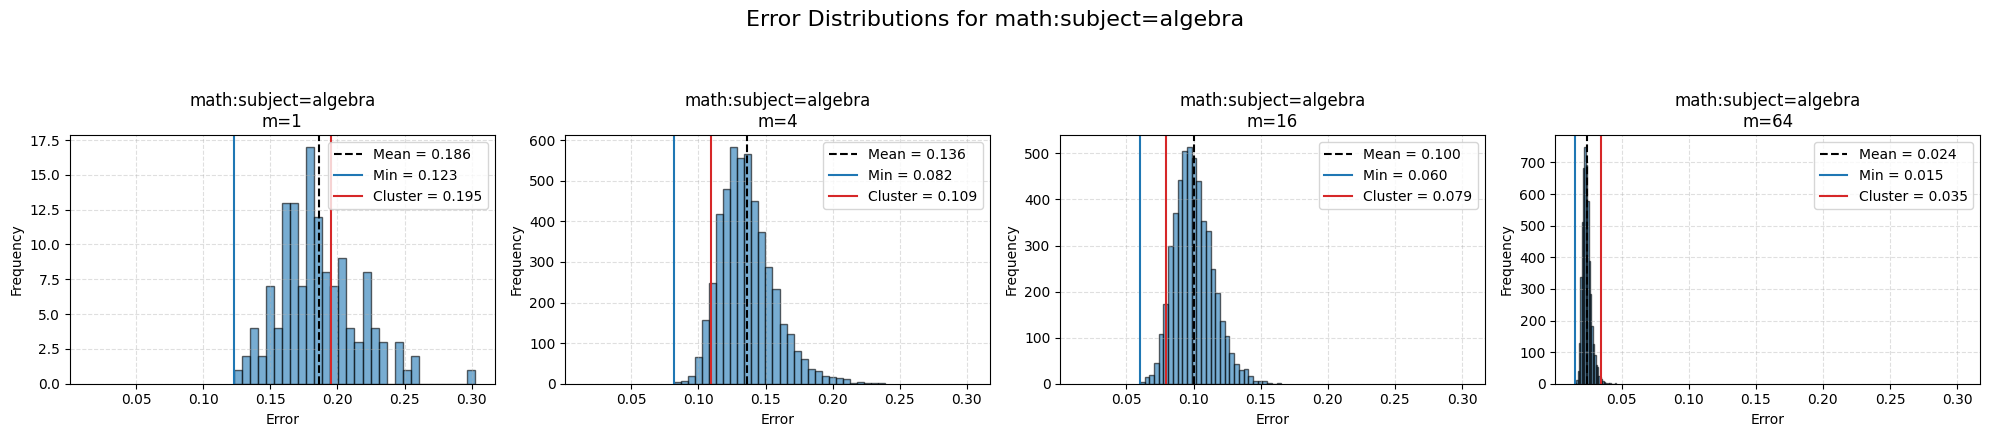

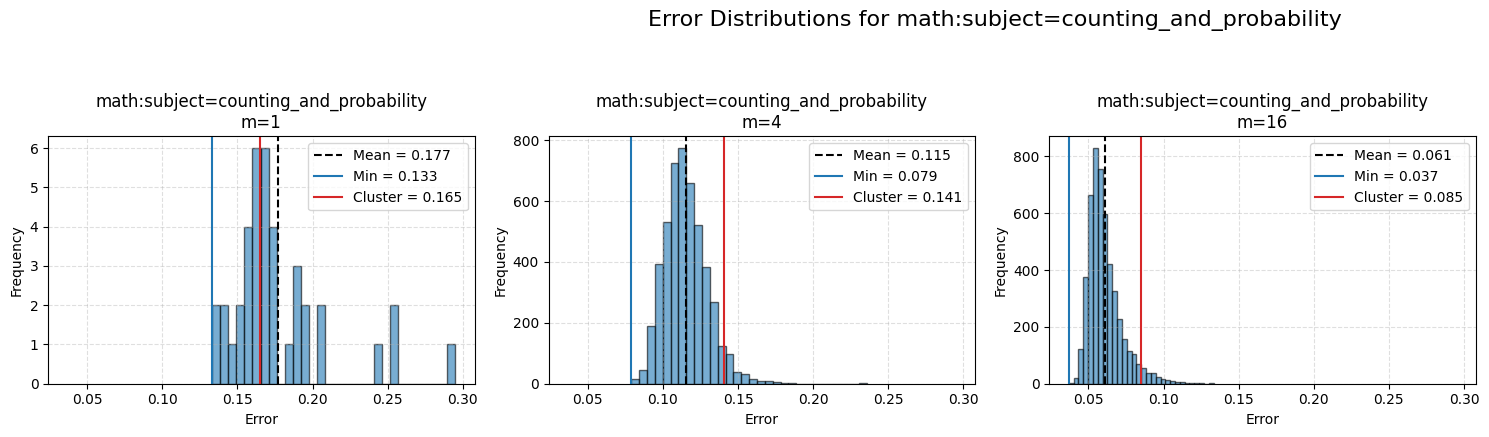

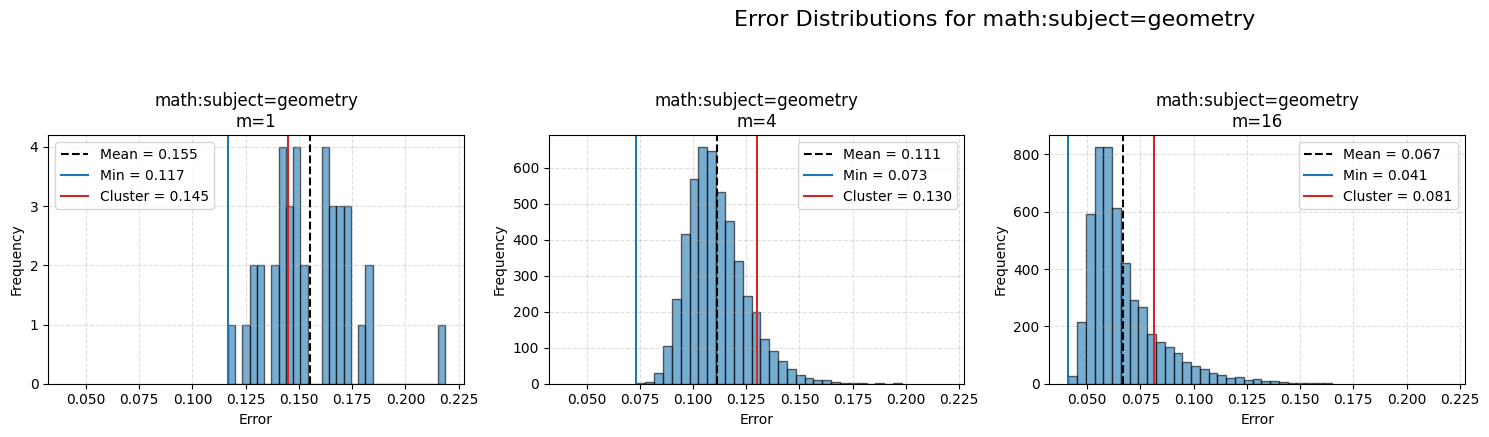

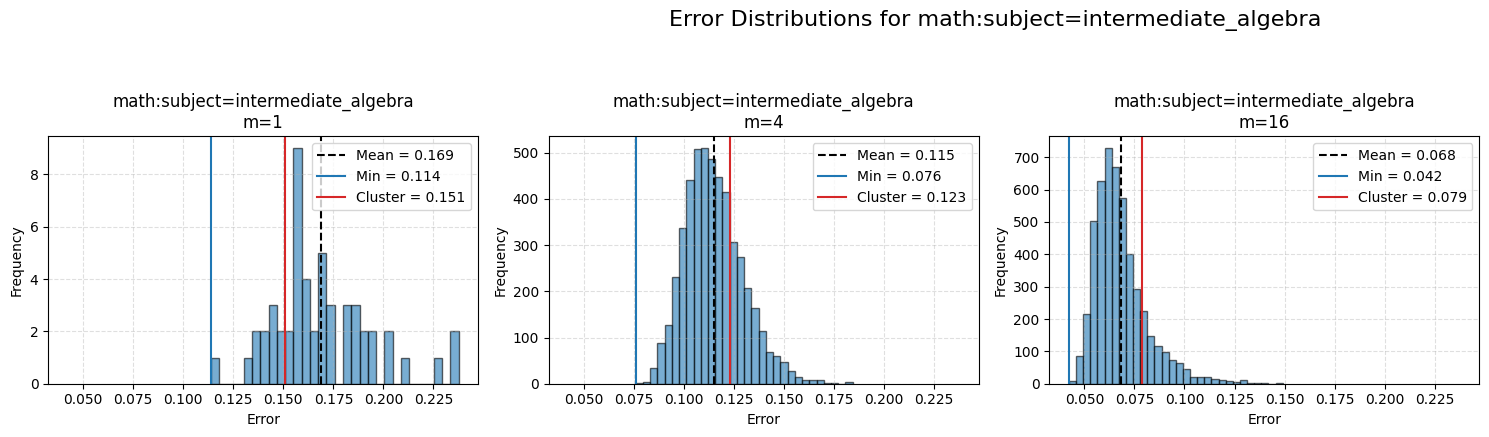

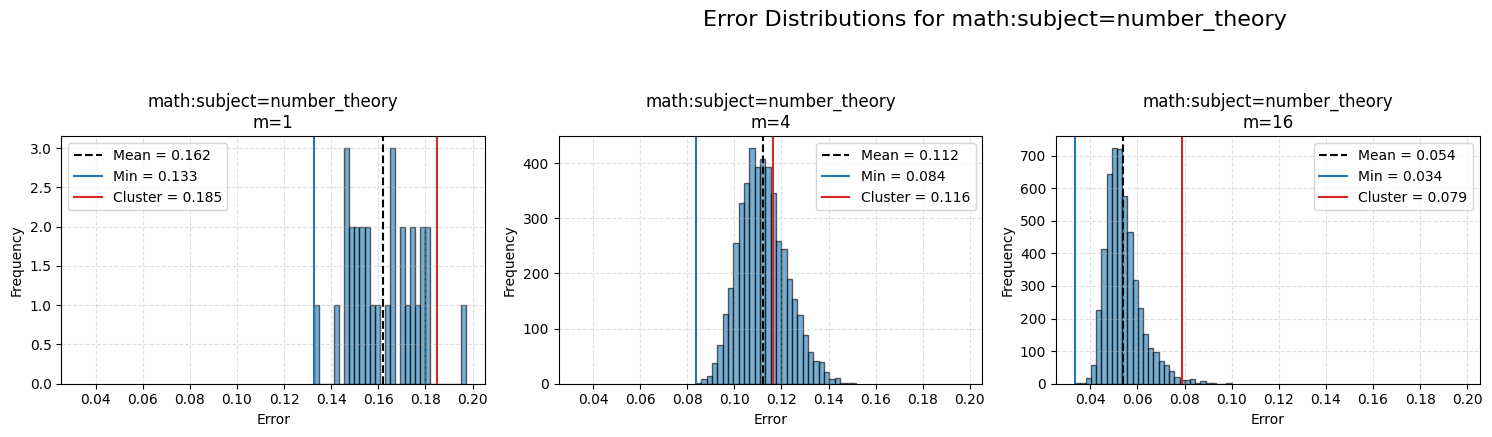

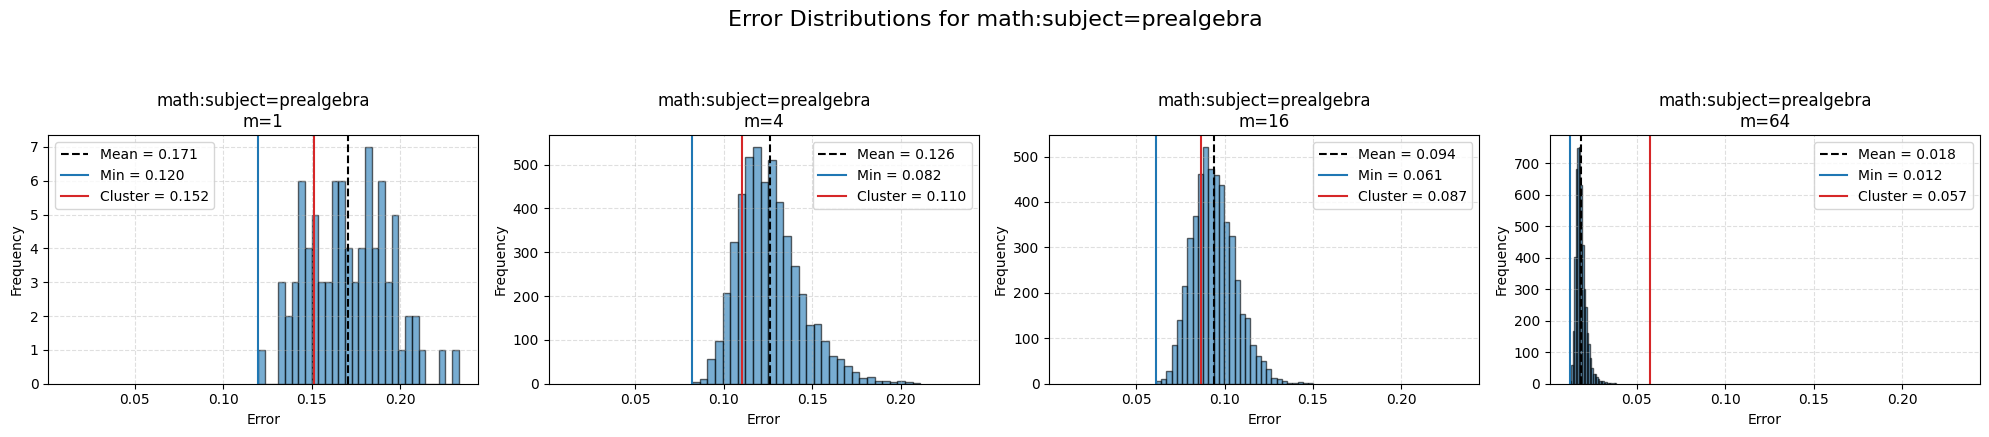

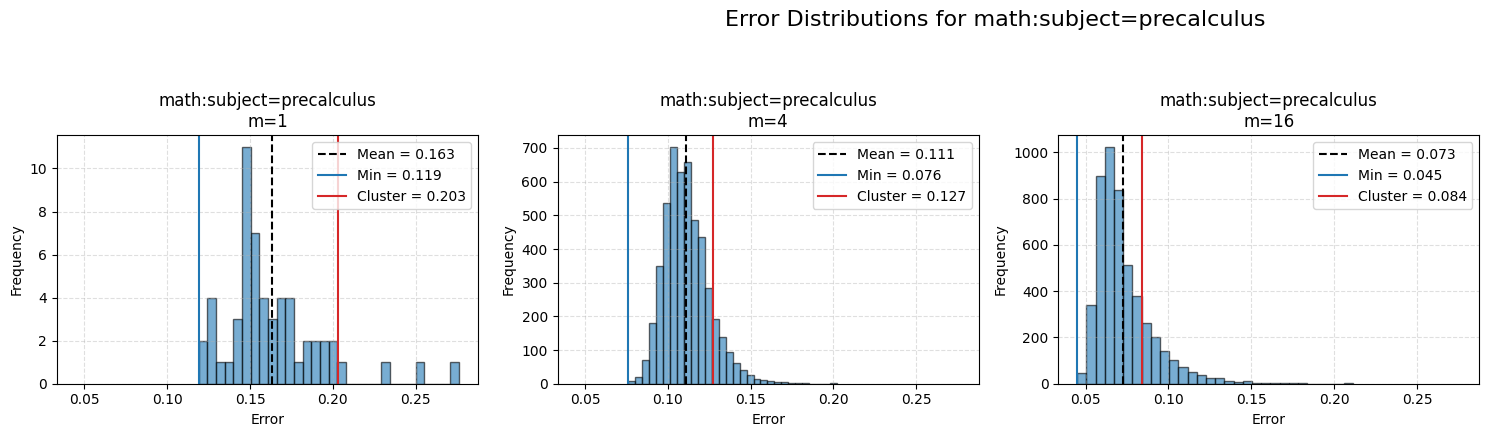

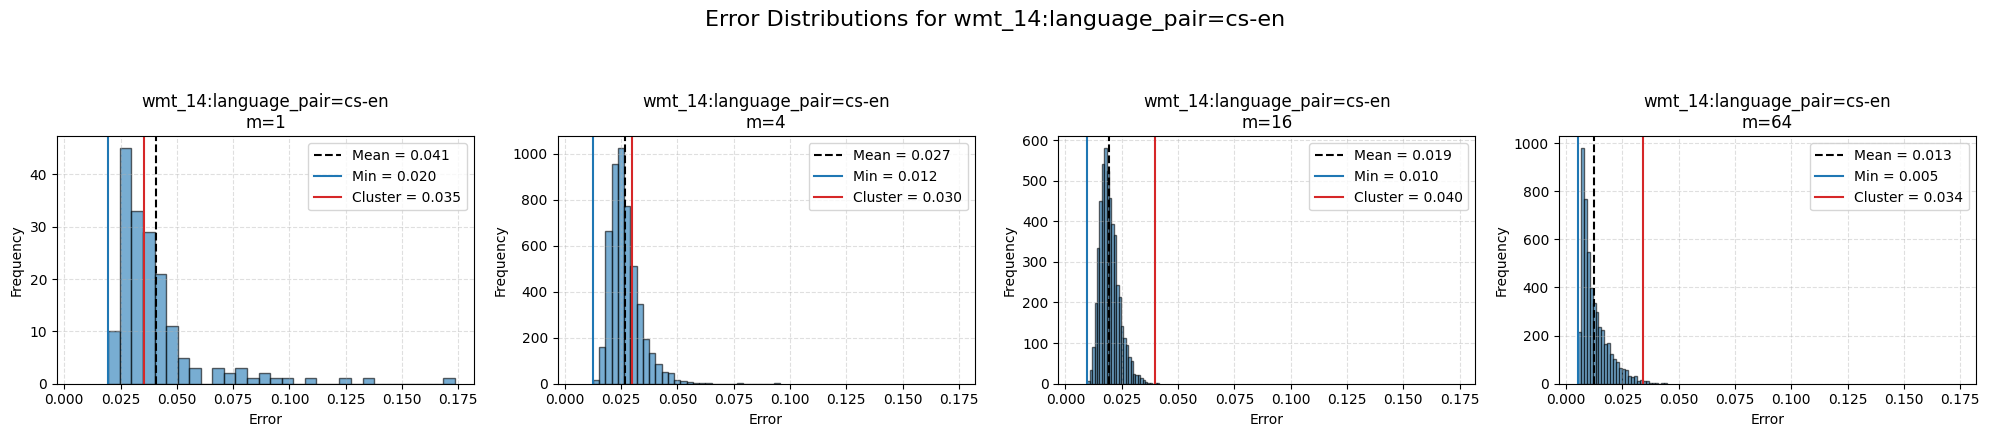

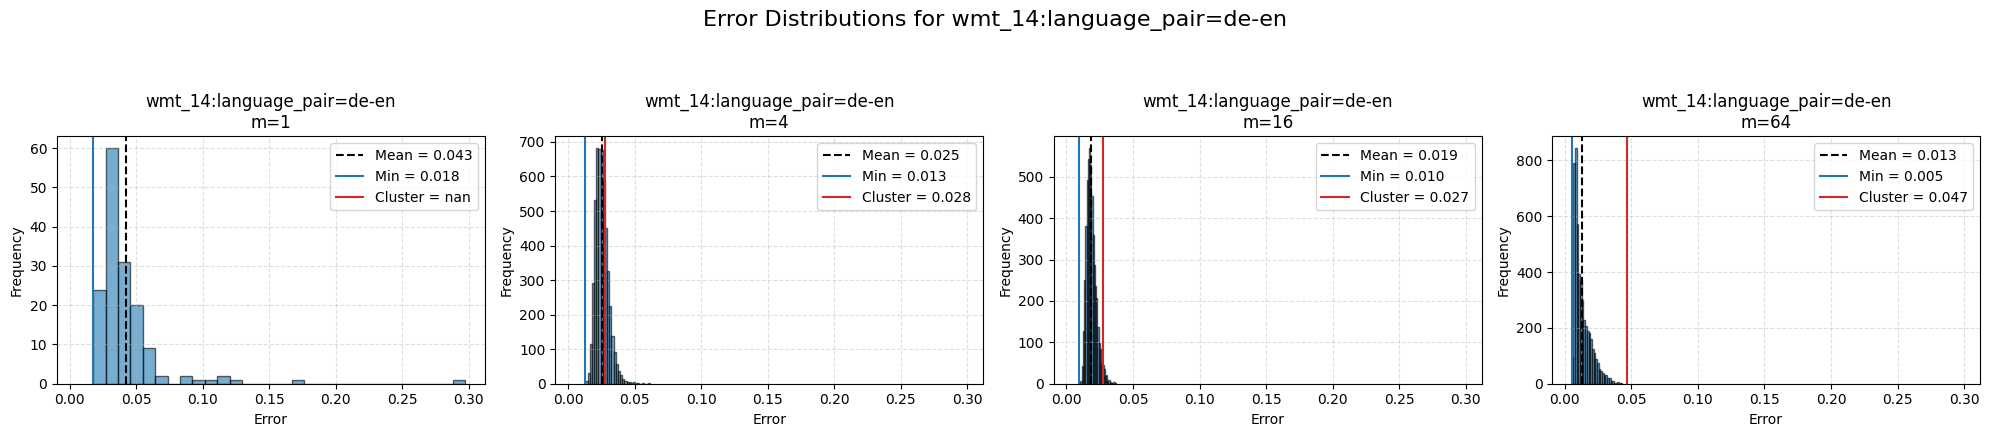

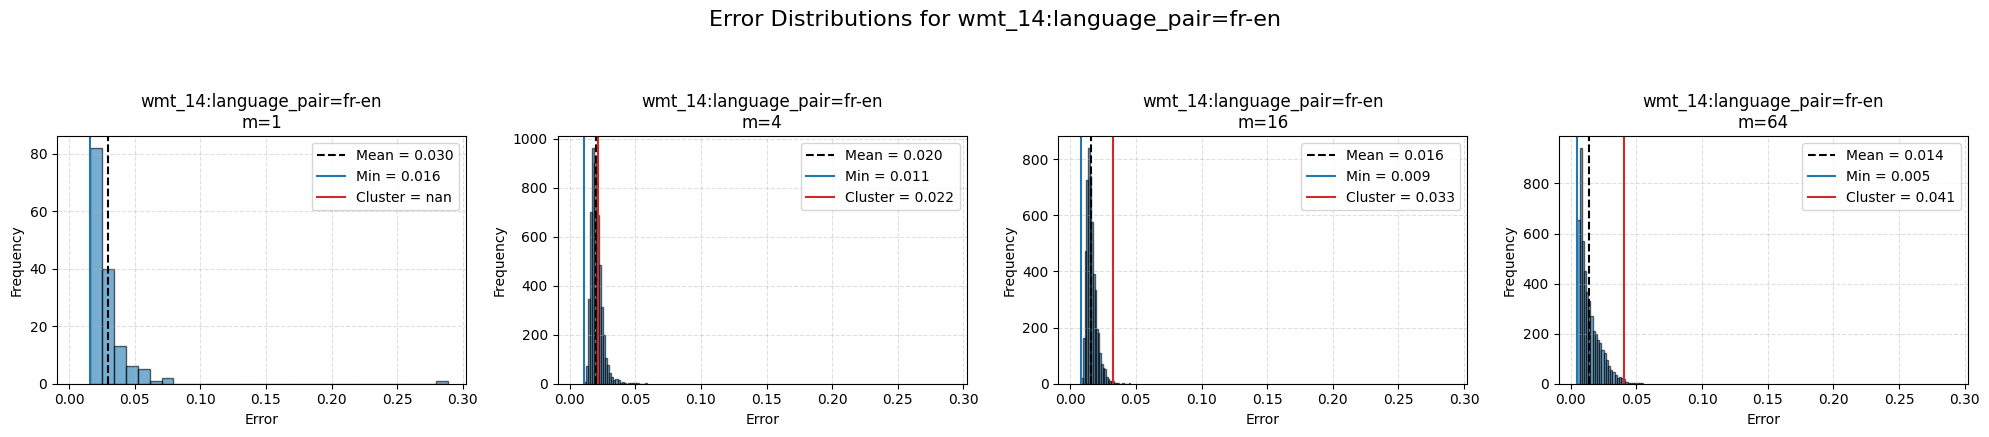

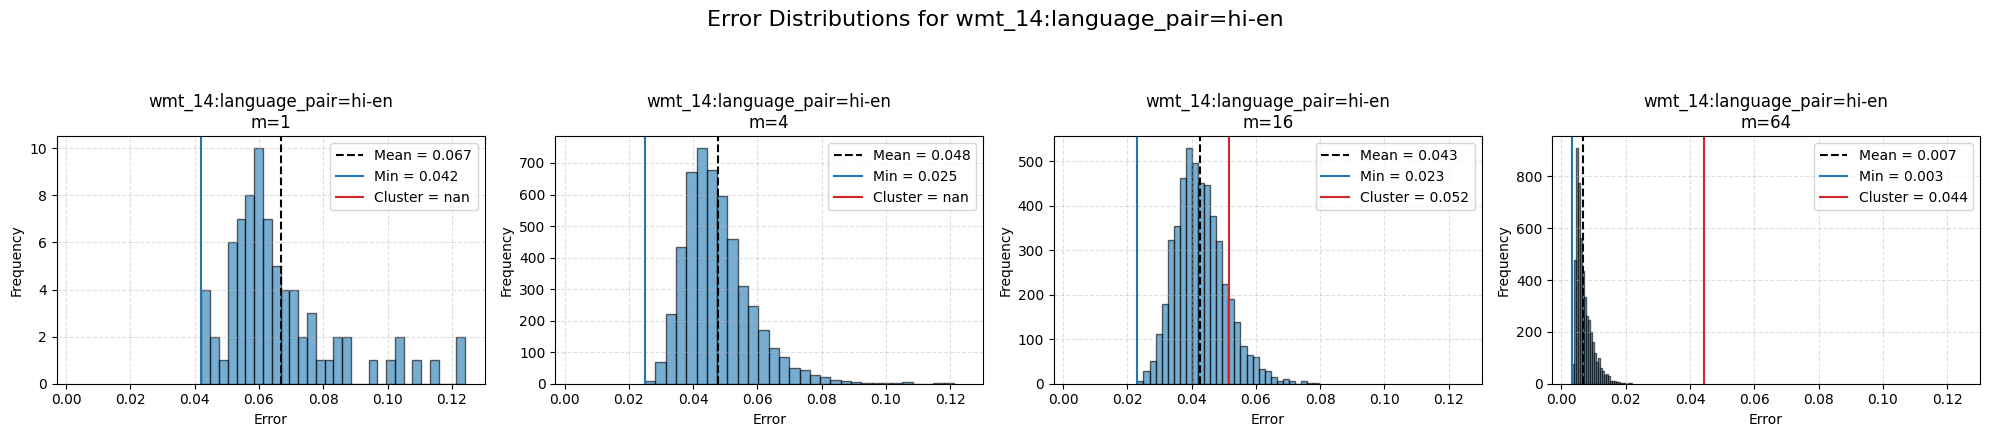

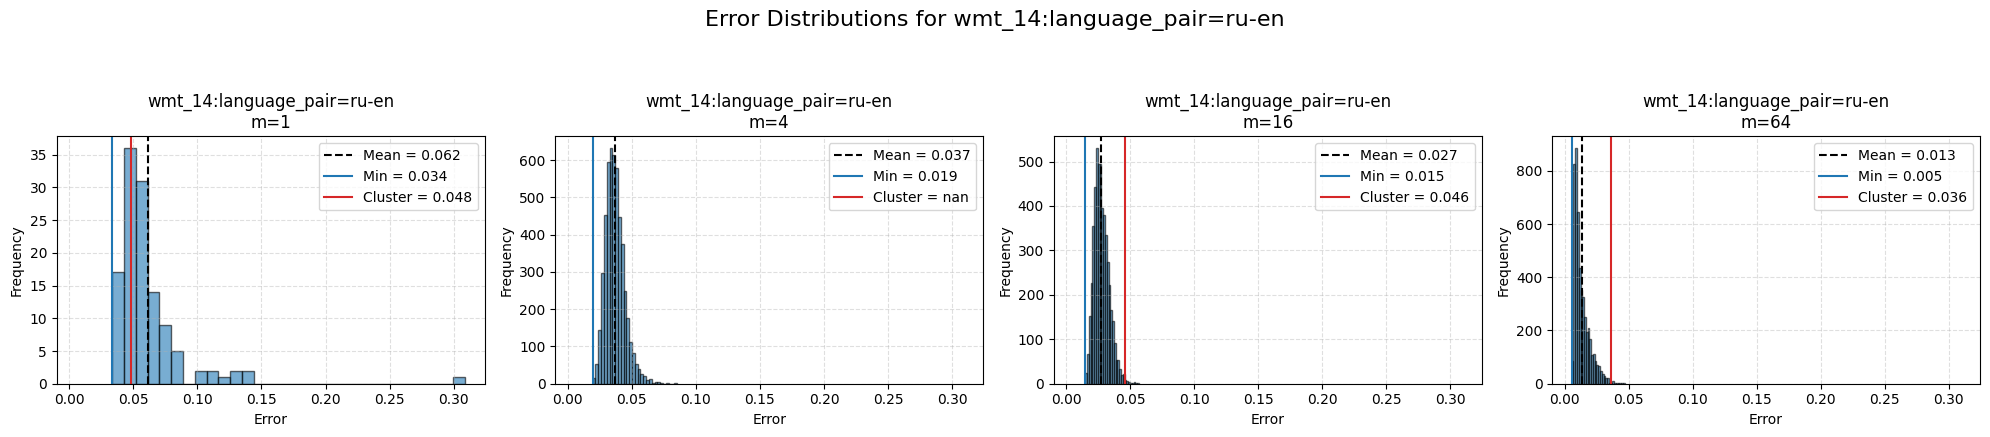

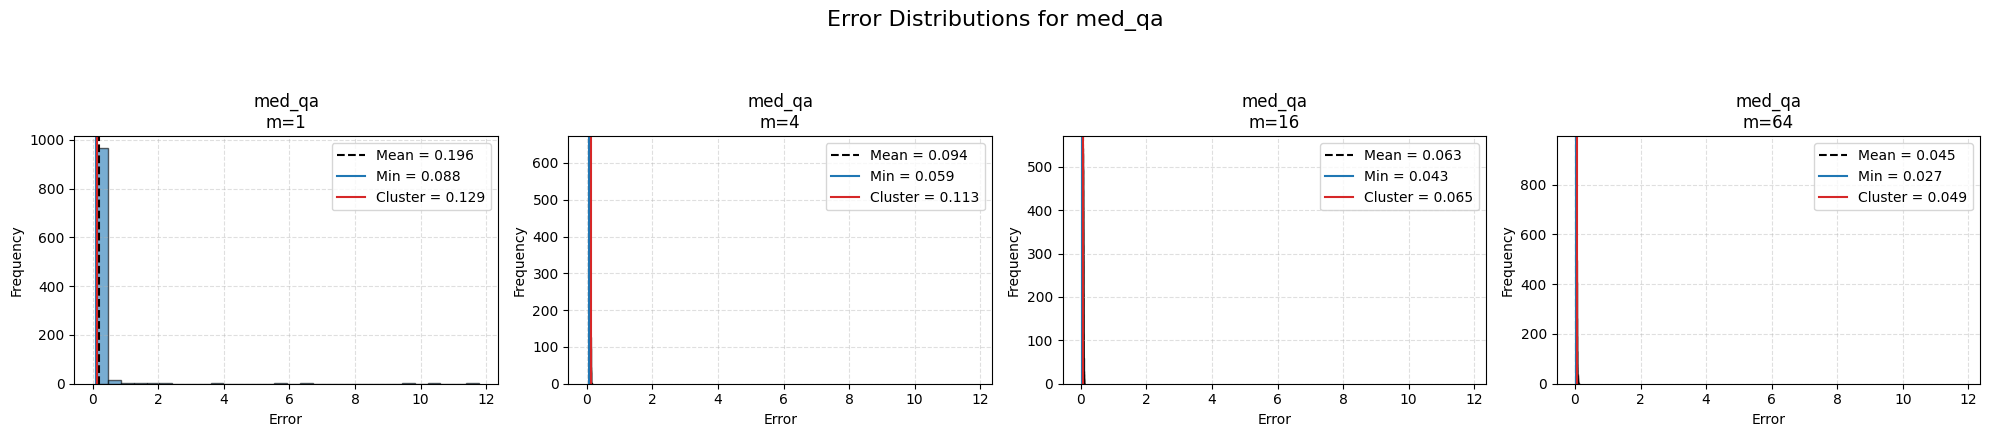

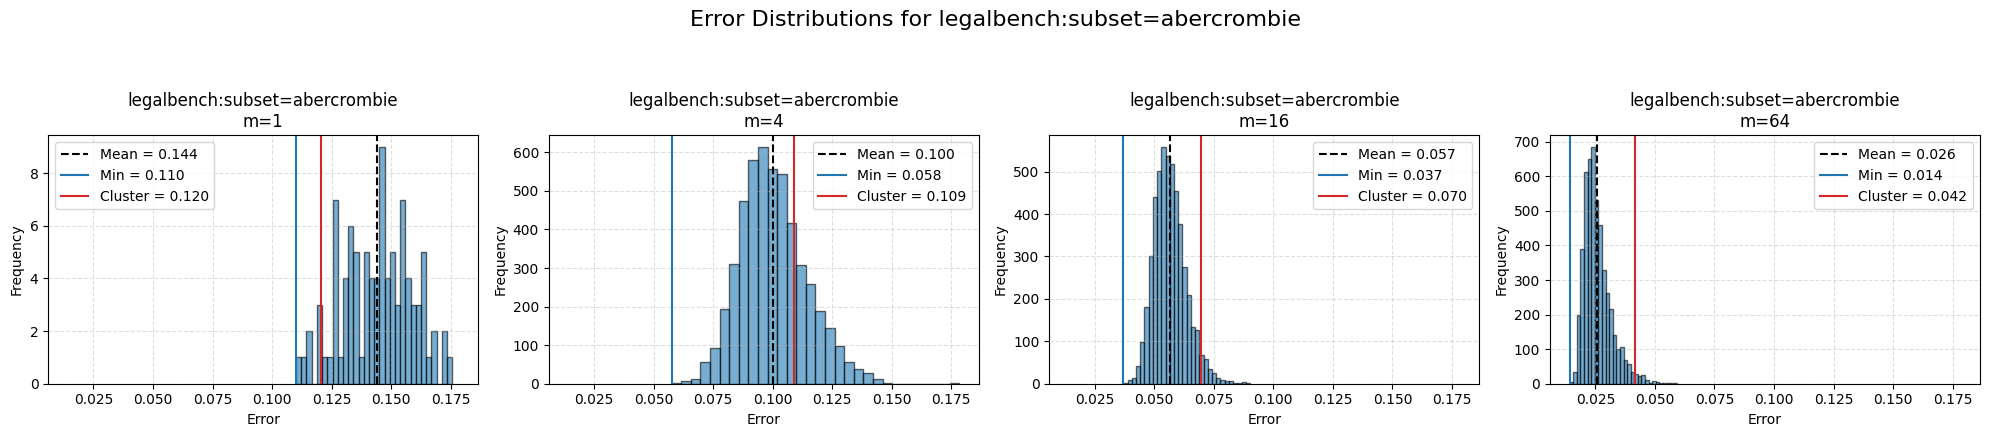

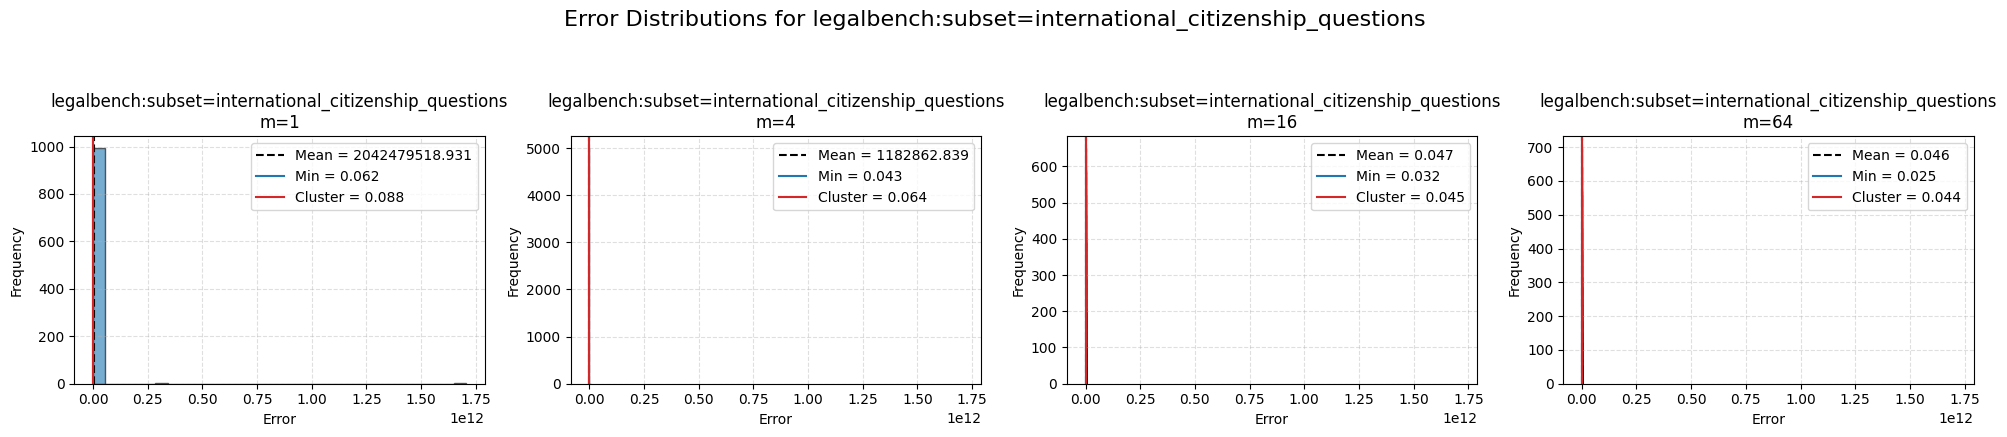

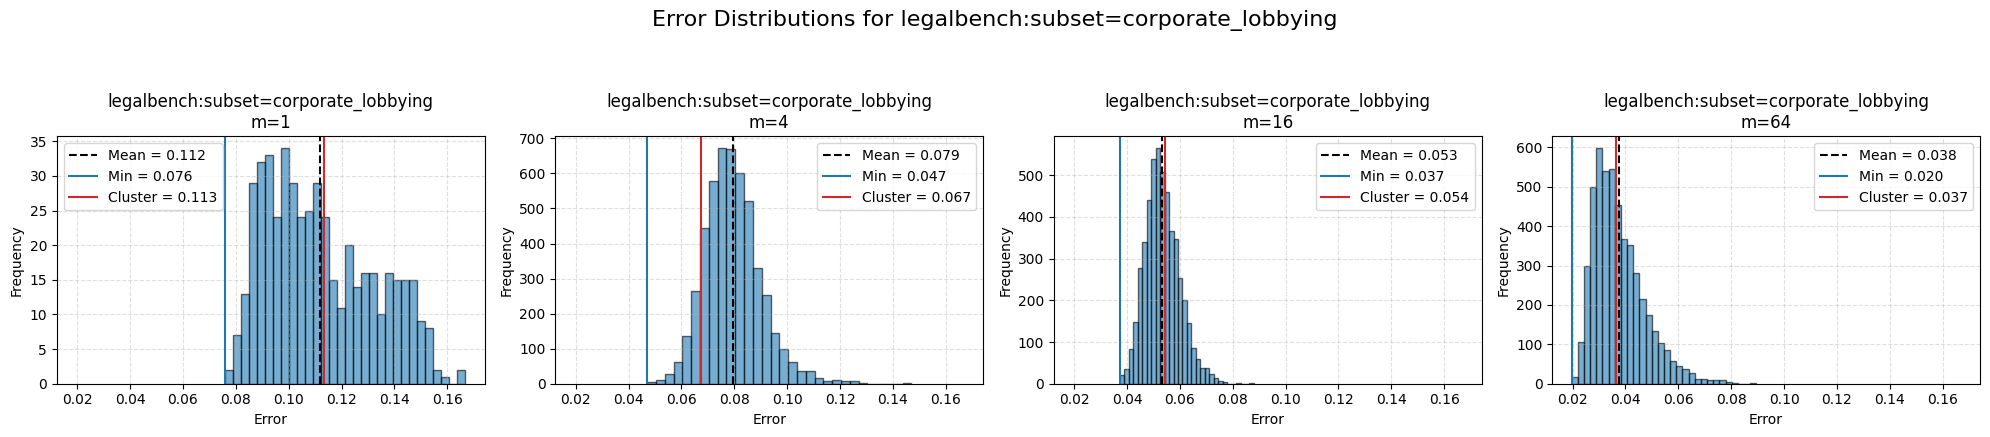

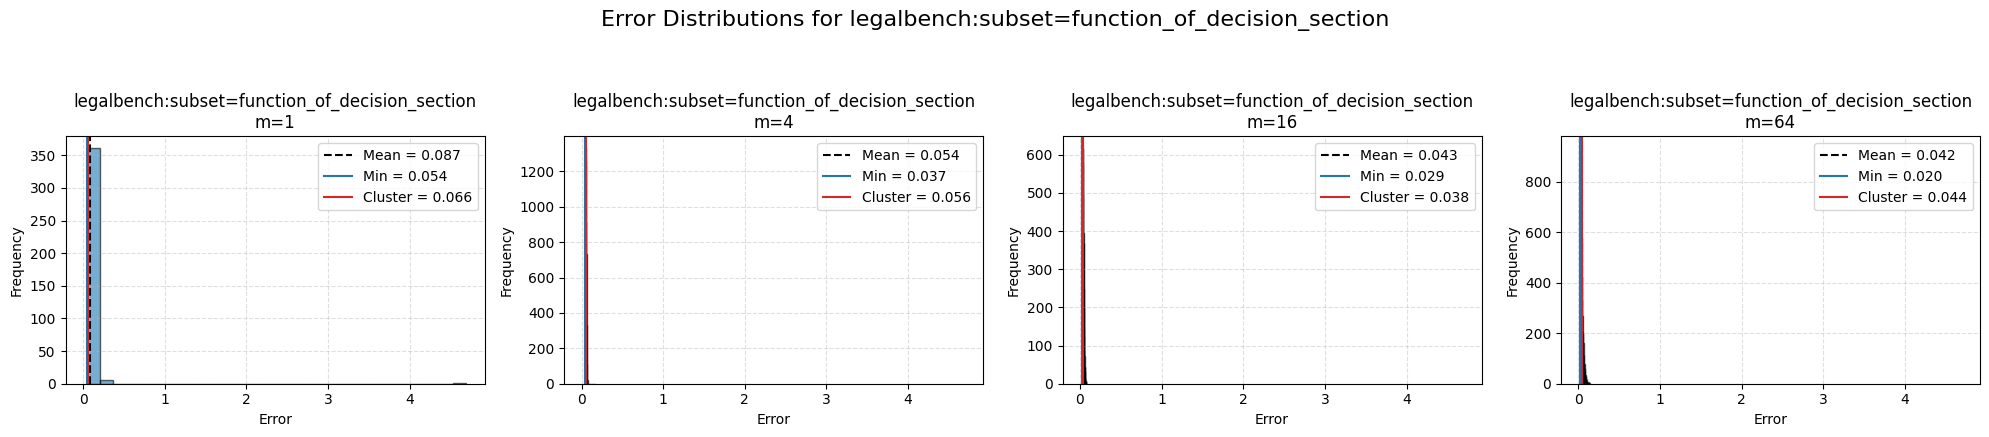

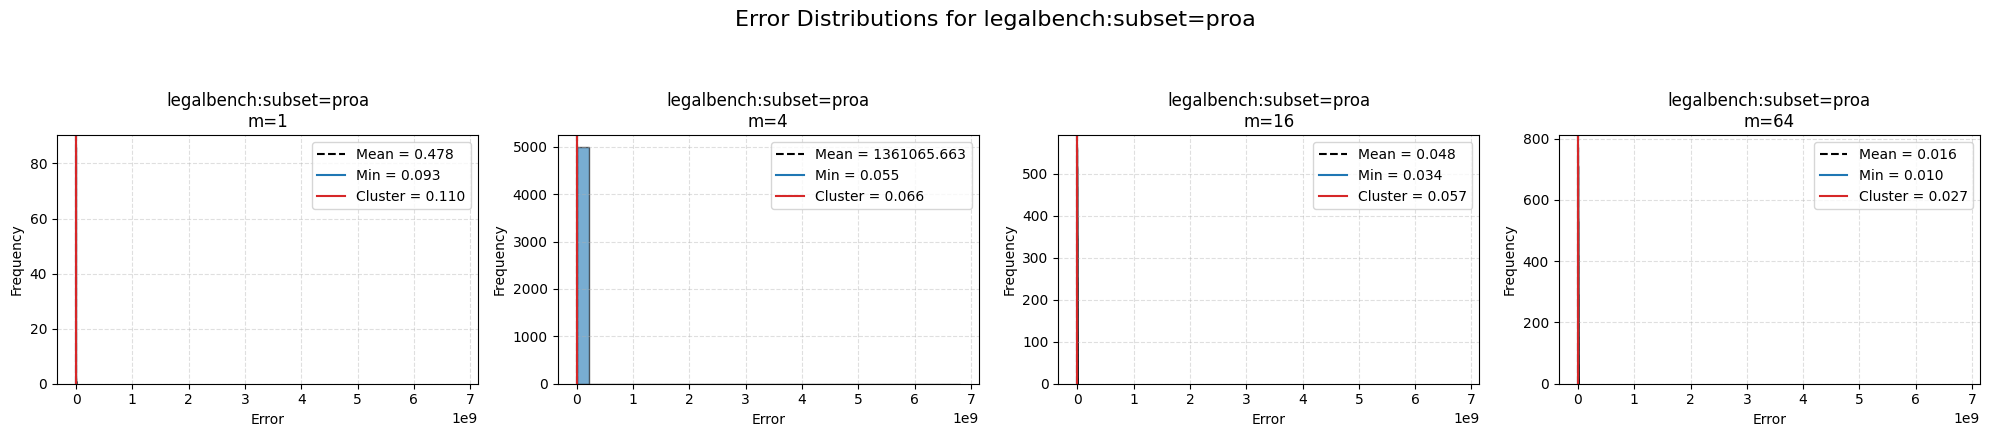

In [4]:
import pickle
import matplotlib.pyplot as plt
instance_id_list_to_error = pickle.load(open('error_distributions.p', 'rb'))

for dataset in instance_id_list_to_error:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)


    for i, n_sample in enumerate(n_sample_list):
        ax = axes[i]

        # for ax, sample_size in zip(axes, subset_sizes):
        errors = list(instance_id_list_to_error[dataset][n_sample].values())
        if not errors:
            ax.set_visible(False)
            continue

        median_val = np.mean(errors)
        max_val = np.min(errors)

        # Plot histogram
        ax.hist(errors, bins=30, alpha=0.6, edgecolor='black')
        ax.axvline(median_val, color='k', linestyle='--', label=f'Mean = {median_val:.3f}')
        ax.axvline(max_val, color='tab:blue', linestyle='-', label=f'Min = {max_val:.3f}')
        ax.axvline(error_dict[dataset][n_sample], color='tab:red', label=f'Cluster = {error_dict[dataset][n_sample]:.3f}')

        ax.set_title(f"{dataset}\nm={n_sample}")
        ax.set_xlabel("Error")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.4)

        plt.tight_layout()
        plt.suptitle(f"Error Distributions for {dataset}", fontsize=16, y=1.08)
        # plt.show()